In [28]:
import tensorflow as tf
print(tf.__version__)

2023-03-24 14:31:35.210631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import numpy as np
import os, fnmatch
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint



In [30]:
# First we want to show to how librosa handles sound signals.
# Let's read an example audio signal using librosa
audio_file_path='siren.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [31]:
librosa_audio_data.shape

(310905,)

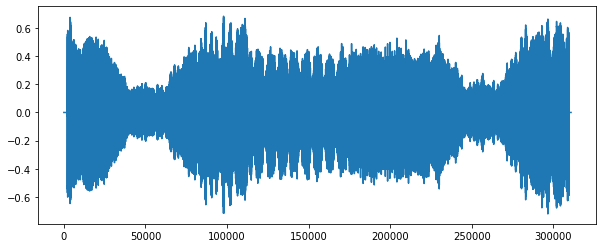

In [32]:
# Plot the librosa audio data
# Audio with 1 channel 
plt.figure(figsize=(10, 4))
plt.plot(librosa_audio_data)
plt.show()

In [33]:
librosa_sample_rate

22050

In [34]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=45)   #n_mfcc: number of MFCCs to return 
print(mfccs.shape)

(45, 608)


In [35]:
mfccs

array([[-499.8979    , -499.8979    , -499.8979    , ..., -122.37127   ,
        -207.34862   , -499.8979    ],
       [   0.        ,    0.        ,    0.        , ...,  108.84964   ,
         105.632324  ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,  -33.749146  ,
         -31.582096  ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.9861502 ,
           0.72147727,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    1.4772466 ,
           2.0283136 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,   -3.5499961 ,
          -2.0889497 ,    0.        ]], dtype=float32)

In [36]:
# The function for extracting MFC coefficients from signals using librosa:

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=45)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

In [37]:
# In order to find all the files in directory:
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename


dataset =[]                
                
for filename in find_files("audio", "*.wav"):    
#    print("Found wav source:", filename)
    label = filename.split(".wav")[0][-5]
    if label == '-':
        label = filename.split(".wav")[0][-6]
    dataset.append({"file_name" : filename, "label" : label})
  
    
    
dataset

[{'file_name': 'audio/fold2/203929-7-5-1.wav', 'label': '7'},
 {'file_name': 'audio/fold2/196384-9-0-2.wav', 'label': '9'},
 {'file_name': 'audio/fold2/169098-7-4-6.wav', 'label': '7'},
 {'file_name': 'audio/fold2/123688-8-0-4.wav', 'label': '8'},
 {'file_name': 'audio/fold2/174994-3-0-0.wav', 'label': '3'},
 {'file_name': 'audio/fold2/18453-3-0-0.wav', 'label': '3'},
 {'file_name': 'audio/fold2/109703-2-0-134.wav', 'label': '0'},
 {'file_name': 'audio/fold2/147926-0-0-44.wav', 'label': '0'},
 {'file_name': 'audio/fold2/123688-8-0-13.wav', 'label': '8'},
 {'file_name': 'audio/fold2/203929-7-7-3.wav', 'label': '7'},
 {'file_name': 'audio/fold2/147926-0-0-50.wav', 'label': '0'},
 {'file_name': 'audio/fold2/169098-7-4-11.wav', 'label': '7'},
 {'file_name': 'audio/fold2/98202-9-0-10.wav', 'label': '9'},
 {'file_name': 'audio/fold2/156893-7-6-0.wav', 'label': '7'},
 {'file_name': 'audio/fold2/189023-0-0-0.wav', 'label': '0'},
 {'file_name': 'audio/fold2/203929-7-6-10.wav', 'label': '7'},
 {

In [38]:
dataset = pd.DataFrame(dataset)

dataset.head()


,file_name,label
0,audio/fold2/203929-7-5-1.wav,7
1,audio/fold2/196384-9-0-2.wav,9
2,audio/fold2/169098-7-4-6.wav,7
3,audio/fold2/123688-8-0-4.wav,8
4,audio/fold2/174994-3-0-0.wav,3


In [39]:
dataset.shape

(8732, 2)

In [40]:
# Let's iterate every sound file and extract features using MFC Coefficients of librosa 
# using features_extractor method we defined above:
extracted_features=[]

dataset['data'] = dataset['file_name'].apply(features_extractor)


/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [41]:
dataset.head()

,file_name,label,data
0,audio/fold2/203929-7-5-1.wav,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,audio/fold2/196384-9-0-2.wav,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,audio/fold2/169098-7-4-6.wav,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,audio/fold2/123688-8-0-4.wav,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,audio/fold2/174994-3-0-0.wav,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [42]:
# Let's change column names:
dataset = dataset.rename(columns={'label': 'class'})
dataset = dataset.rename(columns={'data': 'feature'})

In [43]:
dataset.head()

,file_name,class,feature
0,audio/fold2/203929-7-5-1.wav,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,audio/fold2/196384-9-0-2.wav,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,audio/fold2/169098-7-4-6.wav,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,audio/fold2/123688-8-0-4.wav,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,audio/fold2/174994-3-0-0.wav,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [44]:
# Dropping unnecessary column from dataframe..
dataset.drop(['file_name'], axis=1, inplace=True)

In [45]:
dataset.head()

,class,feature
0,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [46]:
# We will convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(dataset,columns=['class','feature'])
extracted_features_df.head()

,class,feature
0,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [47]:
# We then split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [48]:
X.shape

(8732, 45)

In [49]:
X

array([[-1.5331117e+02,  1.7435437e+02, -3.3579758e+01, ...,
        -5.0225902e-01, -3.9603736e+00,  2.9388754e+00],
       [-1.2262848e+02,  9.8150810e+01,  2.2810329e+01, ...,
         4.7464952e+00, -4.0669475e+00, -1.7328404e+00],
       [-1.1339708e+02,  1.3308368e+02, -1.3934238e+01, ...,
        -4.7859182e+00, -9.1339636e+00, -3.5373797e+00],
       ...,
       [-3.9577615e+02,  1.1766896e+02, -1.8984079e+01, ...,
         1.1930171e+00, -3.3352229e-01,  8.4444962e-02],
       [-1.4109282e+02,  4.5605965e+01, -3.0348949e+01, ...,
        -2.9537885e+00,  8.1303328e-01, -2.9190287e-01],
       [-3.3148029e+02,  7.4129967e+01, -8.5728676e+01, ...,
         1.8560742e+00, -2.1112416e+00, -3.9246848e-01]], dtype=float32)

In [50]:
y

array(['7', '9', '7', ..., '8', '4', '2'], dtype='<U1')

In [51]:
y.shape

(8732,)

In [52]:
# We should perform Label Encoding since we need one hot encoded values for output classes in our model (1s and 0s)

# Please remember one-hot encoding:
# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [53]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [54]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [55]:
# We split dataset as Train and Test

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [56]:

X_train

array([[-3.63208008e+02,  1.45407867e+02, -1.63843060e+01, ...,
        -2.90608048e+00, -1.92613459e+00, -1.49026883e+00],
       [-2.10693893e+02, -3.88140082e+00,  1.03220253e+01, ...,
        -2.86087370e+00,  1.67725968e+00, -1.25391626e+00],
       [-5.78228271e+02,  1.64271561e+02, -1.21265030e+01, ...,
         4.05884933e+00,  5.88118315e+00,  2.66645670e-01],
       ...,
       [-2.98379822e+02,  1.61720917e+02,  4.10926938e-01, ...,
         1.26204073e+00, -2.81716061e+00, -2.92051077e+00],
       [-1.08986465e+02,  9.32904663e+01, -1.55975409e+01, ...,
        -3.37805533e+00, -3.26974440e+00, -2.76076555e+00],
       [-2.31185104e+02,  1.63369461e+02, -2.41354351e+01, ...,
         3.42792463e+00,  8.79246616e+00,  8.59628773e+00]], dtype=float32)

In [57]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [58]:
X_train.shape

(6985, 45)

In [59]:
X_test.shape

(1747, 45)

In [60]:
y_train.shape

(6985, 10)

In [61]:
y_test.shape

(1747, 10)

In [62]:
num_labels = 10

In [63]:
# Now we start building our CNN model..

model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(45,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2023-03-24 14:40:54.659001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5750      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [65]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [66]:
# Trianing the model

epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 2s 3ms/step - loss: 8.8323 - accuracy: 0.1278 - val_loss: 2.2856 - val_accuracy: 0.1339
Epoch 2/300
219/219 [==============================] - 0s 2ms/step - loss: 2.4537 - accuracy: 0.1300 - val_loss: 2.2714 - val_accuracy: 0.1345
Epoch 3/300
219/219 [==============================] - 0s 2ms/step - loss: 2.3065 - accuracy: 0.1370 - val_loss: 2.2293 - val_accuracy: 0.1723
Epoch 4/300
219/219 [==============================] - 0s 2ms/step - loss: 2.2653 - accuracy: 0.1691 - val_loss: 2.1863 - val_accuracy: 0.2049
Epoch 5/300
219/219 [==============================] - 0s 2ms/step - loss: 2.1916 - accuracy: 0.1824 - val_loss: 2.1051 - val_accuracy: 0.2318
Epoch 6/300
219/219 [==============================] - 0s 2ms/step - loss: 2.1467 - accuracy: 0.1964 - val_loss: 2.0506 - val_accuracy: 0.2387
Epoch 7/300
219/219 [==============================] - 0s 2ms/step - loss: 2.0873 - accuracy: 0.2155 - val_loss: 1.9909 - val_accuracy: 0.2656

Epoch 58/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9501 - accuracy: 0.6806 - val_loss: 0.7662 - val_accuracy: 0.7584
Epoch 59/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9840 - accuracy: 0.6817 - val_loss: 0.7814 - val_accuracy: 0.7516
Epoch 60/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9390 - accuracy: 0.6896 - val_loss: 0.7747 - val_accuracy: 0.7579
Epoch 61/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9464 - accuracy: 0.6875 - val_loss: 0.7933 - val_accuracy: 0.7499
Epoch 62/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9487 - accuracy: 0.6892 - val_loss: 0.7780 - val_accuracy: 0.7550
Epoch 63/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9295 - accuracy: 0.6909 - val_loss: 0.7683 - val_accuracy: 0.7533
Epoch 64/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9297 - accuracy: 0.6943 - val_loss: 0.7682 - val_accuracy:

Epoch 115/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8378 - accuracy: 0.7317 - val_loss: 0.6573 - val_accuracy: 0.7945
Epoch 116/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8132 - accuracy: 0.7306 - val_loss: 0.6919 - val_accuracy: 0.7853
Epoch 117/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8327 - accuracy: 0.7314 - val_loss: 0.6861 - val_accuracy: 0.7853
Epoch 118/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8467 - accuracy: 0.7266 - val_loss: 0.6629 - val_accuracy: 0.7985
Epoch 119/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8330 - accuracy: 0.7288 - val_loss: 0.6860 - val_accuracy: 0.7934
Epoch 120/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8195 - accuracy: 0.7317 - val_loss: 0.6858 - val_accuracy: 0.7790
Epoch 121/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8160 - accuracy: 0.7306 - val_loss: 0.6945 - val_ac

219/219 [==============================] - 0s 2ms/step - loss: 0.7746 - accuracy: 0.7419 - val_loss: 0.6384 - val_accuracy: 0.8065
Epoch 172/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7727 - accuracy: 0.7486 - val_loss: 0.6437 - val_accuracy: 0.7922
Epoch 173/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7916 - accuracy: 0.7403 - val_loss: 0.6421 - val_accuracy: 0.8105
Epoch 174/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7848 - accuracy: 0.7433 - val_loss: 0.6412 - val_accuracy: 0.7979
Epoch 175/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7735 - accuracy: 0.7439 - val_loss: 0.6456 - val_accuracy: 0.7905
Epoch 176/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7637 - accuracy: 0.7482 - val_loss: 0.6178 - val_accuracy: 0.8077
Epoch 177/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7860 - accuracy: 0.7430 - val_loss: 0.6434 - val_accuracy: 0.8031

219/219 [==============================] - 0s 2ms/step - loss: 0.7442 - accuracy: 0.7615 - val_loss: 0.6145 - val_accuracy: 0.8117
Epoch 228/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7487 - accuracy: 0.7606 - val_loss: 0.6112 - val_accuracy: 0.8122
Epoch 229/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7361 - accuracy: 0.7548 - val_loss: 0.6195 - val_accuracy: 0.8105
Epoch 230/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7425 - accuracy: 0.7586 - val_loss: 0.6448 - val_accuracy: 0.8037
Epoch 231/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7366 - accuracy: 0.7596 - val_loss: 0.6278 - val_accuracy: 0.8122
Epoch 232/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7429 - accuracy: 0.7573 - val_loss: 0.6200 - val_accuracy: 0.8060
Epoch 233/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7408 - accuracy: 0.7548 - val_loss: 0.5848 - val_accuracy: 0.8203

219/219 [==============================] - 0s 2ms/step - loss: 0.7351 - accuracy: 0.7571 - val_loss: 0.5929 - val_accuracy: 0.8145
Epoch 284/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7269 - accuracy: 0.7642 - val_loss: 0.6092 - val_accuracy: 0.8071
Epoch 285/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7181 - accuracy: 0.7684 - val_loss: 0.5752 - val_accuracy: 0.8231
Epoch 286/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7147 - accuracy: 0.7718 - val_loss: 0.5803 - val_accuracy: 0.8203
Epoch 287/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7208 - accuracy: 0.7699 - val_loss: 0.5839 - val_accuracy: 0.8122
Epoch 288/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7176 - accuracy: 0.7641 - val_loss: 0.5924 - val_accuracy: 0.8191
Epoch 289/300
219/219 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.7725 - val_loss: 0.5993 - val_accuracy: 0.8128

In [67]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8076702952384949


In [68]:
X_test[1]

array([-3.79699432e+02,  1.27056946e+02,  4.13146553e+01,  2.53245850e+01,
        3.63546333e+01,  2.72242336e+01,  1.67799072e+01,  1.48400888e+01,
        1.56829138e+01,  1.95568924e+01,  1.68035946e+01,  6.67904806e+00,
        4.53648329e+00,  8.99429989e+00,  8.67832470e+00,  5.78463793e+00,
        4.04143810e+00,  2.47633100e+00,  1.68370616e+00,  1.30639577e+00,
        1.66607511e+00,  4.02205086e+00,  5.45846701e+00,  5.51119184e+00,
        7.07395744e+00,  7.73054504e+00,  5.30996895e+00,  2.80563259e+00,
        8.02111864e-01, -8.96958828e-01, -6.82695284e-02,  1.81169593e+00,
        1.50324190e+00,  3.54312241e-01,  8.92794132e-01,  2.49078202e+00,
        3.13518047e+00,  2.85444093e+00,  2.87297392e+00,  2.35716462e+00,
        1.62833774e+00,  2.83129787e+00,  3.22105169e+00,  5.45518041e-01,
       -3.07951905e-02], dtype=float32)

In [69]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

55/55 [==============================] - 0s 887us/step


In [70]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline
from IPython.display import Audio, IFrame, display
import librosa.display

In [71]:
sr = 16000
e_file1 = 'bark.wav'
noise_data,rate = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)

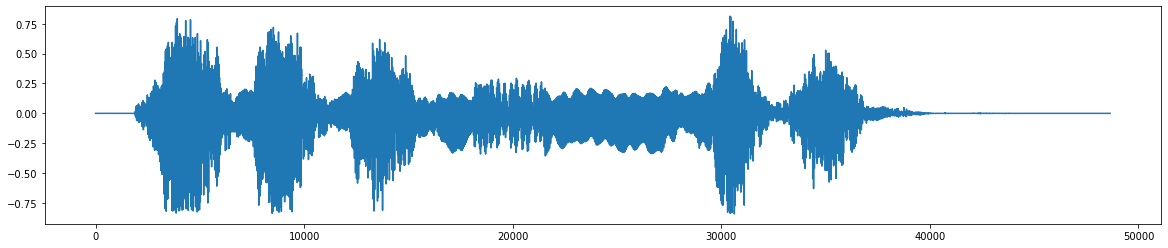

In [72]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

In [73]:
IPython.display.Audio(data=noise_data, rate=rate)

In [74]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(noise_data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = noise_data+noise

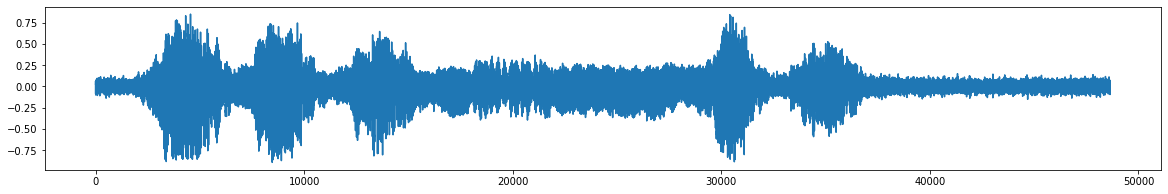

In [75]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [76]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

In [77]:
# non stationary noise reduction
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, thresh_n_mult_nonstationary=2,stationary=False)

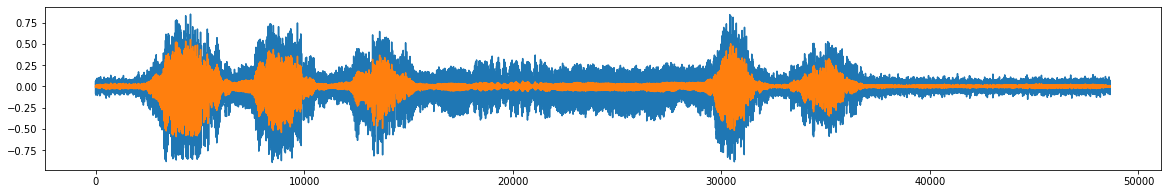

In [78]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)
ax.plot(reduced_noise, alpha = 1)
IPython.display.Audio(data=reduced_noise, rate=rate)

In [79]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [80]:
sf.write('ns_reduced_bark.wav', reduced_noise,sr)

In [81]:
filename="ns_reduced_bark.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=45)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [82]:
print(mfccs_scaled_features)

[-3.38291992e+02  3.38185959e+01 -3.03493671e+01  5.67692299e+01
 -5.47293968e+01 -1.49270134e+01 -4.56622276e+01 -4.93216467e+00
 -1.83153229e+01 -2.86027069e+01 -7.27613831e+00 -1.05805101e+01
  1.09607019e+01 -2.01747494e+01 -8.85987854e+00 -1.35954084e+01
 -1.56703889e+00  2.17358947e+00  3.35611343e-01  1.09694471e+01
  2.42138076e+00  1.05435219e+01  1.40725076e+00  9.61763668e+00
  3.68483973e+00  7.98506439e-02  1.05829135e-01 -2.80516934e+00
  9.18276072e-01 -4.67625046e+00  1.75627208e+00 -9.23841238e-01
  9.40615654e-01 -3.66487455e+00 -3.83730006e+00 -1.43342853e+00
 -2.60591221e+00 -5.07782698e-01 -3.88616109e+00 -9.18827593e-01
 -2.34539986e+00  1.16495895e+00  1.35579979e+00  1.40925598e+00
 -2.42588952e-01]


In [83]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [84]:
mfccs_scaled_features.shape

(1, 45)

In [85]:
print(mfccs_scaled_features)

[[-3.38291992e+02  3.38185959e+01 -3.03493671e+01  5.67692299e+01
  -5.47293968e+01 -1.49270134e+01 -4.56622276e+01 -4.93216467e+00
  -1.83153229e+01 -2.86027069e+01 -7.27613831e+00 -1.05805101e+01
   1.09607019e+01 -2.01747494e+01 -8.85987854e+00 -1.35954084e+01
  -1.56703889e+00  2.17358947e+00  3.35611343e-01  1.09694471e+01
   2.42138076e+00  1.05435219e+01  1.40725076e+00  9.61763668e+00
   3.68483973e+00  7.98506439e-02  1.05829135e-01 -2.80516934e+00
   9.18276072e-01 -4.67625046e+00  1.75627208e+00 -9.23841238e-01
   9.40615654e-01 -3.66487455e+00 -3.83730006e+00 -1.43342853e+00
  -2.60591221e+00 -5.07782698e-01 -3.88616109e+00 -9.18827593e-01
  -2.34539986e+00  1.16495895e+00  1.35579979e+00  1.40925598e+00
  -2.42588952e-01]]


In [86]:
print(mfccs_scaled_features.shape)

(1, 45)


In [87]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 24ms/step


In [88]:
result_array

array([[0.12470859, 0.01689699, 0.10472696, 0.19668703, 0.09171575,
        0.0399451 , 0.04910783, 0.00125993, 0.02179467, 0.3531571 ]],
      dtype=float32)

In [89]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

street_music


55/55 [==============================] - 0s 871us/step
[[175   0  21   3   1   0   0   3   7  11]
 [  2  69   1   1   6   0   1   4   1  12]
 [ 20   0 143   5   3   0   0   3   0   5]
 [  2   0  29 174   0   0   2   0   7  17]
 [  3   0   2   4 178   0   0   8   1   7]
 [ 10   0  17   0   0 167   0   0   3  12]
 [  5   0   9  11   0   2  45   0   0   1]
 [  2   0   0   0   3   0   0 202   0   4]
 [  0   0   6   2   2   1   0   2 146   1]
 [ 24   0  20   3   2   2   0   0   0 112]]


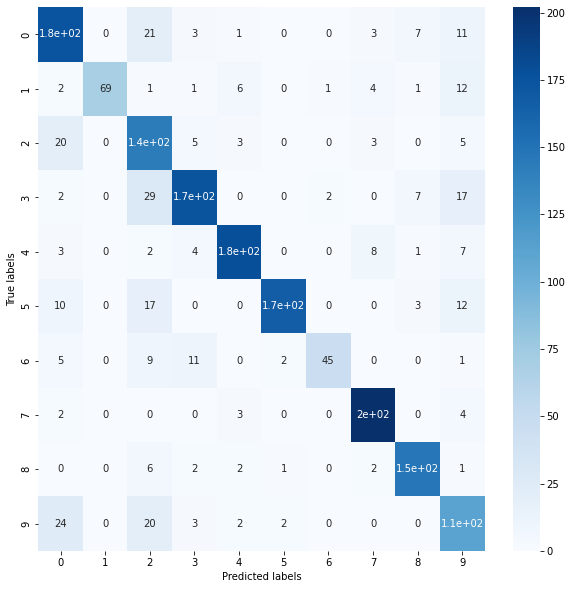

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Get the confusion matrix
cm = confusion_matrix(y_test_int, y_pred)
print(cm)


# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [91]:
from sklearn.metrics import classification_report
report = classification_report(y_test_int, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       221
           1       1.00      0.71      0.83        97
           2       0.58      0.80      0.67       179
           3       0.86      0.75      0.80       231
           4       0.91      0.88      0.89       203
           5       0.97      0.80      0.88       209
           6       0.94      0.62      0.74        73
           7       0.91      0.96      0.93       211
           8       0.88      0.91      0.90       160
           9       0.62      0.69      0.65       163

    accuracy                           0.81      1747
   macro avg       0.84      0.79      0.81      1747
weighted avg       0.83      0.81      0.81      1747



In [92]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test set accuracy:", accuracy)

Test set accuracy: 0.8076702952384949
